In [2]:
import os
import click
import pandas as pd
import numpy as np
from dwave.system import LeapHybridCQMSampler, LeapHybridSampler
from dimod import ConstrainedQuadraticModel, BinaryQuadraticModel, QuadraticModel, quicksum, dimod
from dotenv import load_dotenv, find_dotenv
import networkx as nx
import random
import matplotlib
try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

In [3]:
# Load Environmental Variables
load_dotenv(find_dotenv())
token = os.environ['DWAVE_API_KEY'] 

In [4]:
def set_up_scenario(w, h, num_poi, num_cs, seed):
    """Build scenario set up with specified parameters.
    
    Args:
        w (int): Width of grid
        h (int): Height of grid
        num_poi (int): Number of points of interest
        num_cs (int): Number of existing charging stations
        seed(in): seed for reproduction
    
    Returns:
        G (networkx graph): Grid graph of size w by h
        pois (list of tuples of ints): A fixed set of points of interest
        charging_stations (list of tuples of ints): 
            Set of current charging locations
        potential_new_cs_nodes (list of tuples of ints): 
            Potential new charging locations
    """

    G = nx.grid_2d_graph(w, h)
    nodes = list(G.nodes)

    random.seed(seed)

    # Identify a fixed set of points of interest
    pois = random.sample(nodes, k=num_poi)

    # Identify a fixed set of current charging locations
    charging_stations = random.sample(nodes, k=num_cs)

    # Identify potential new charging locations
    potential_new_cs_nodes = list(G.nodes() - charging_stations)

    return G, pois, charging_stations, potential_new_cs_nodes


In [5]:
def distance(a, b):
    return (a[0]**2 - 2*a[0]*b[0] + b[0]**2) + (a[1]**2 - 2*a[1]*b[1] + b[1]**2)

In [6]:
def printout_solution(pois, num_poi, charging_stations, num_cs, new_charging_nodes, num_new_cs):
    """Print solution statistics to command line.
    
    Args:
        pois (list of tuples of ints): A fixed set of points of interest
        num_poi (int): Number of points of interest
        charging_stations (list of tuples of ints): 
            A fixed set of current charging locations
        num_cs (int): Number of existing charging stations
        new_charging_nodes (list of tuples of ints): 
            Locations of new charging stations
        num_new_cs (int): Number of new charging stations desired
    
    Returns:
        None.
    """

    print("\nSolution returned: \n------------------")

    print("\nNew charging locations:\t\t\t\t", new_charging_nodes)

    if num_poi > 0:
        poi_avg_dist = [0] * len(new_charging_nodes)
        for loc in pois:
            for i, new in enumerate(new_charging_nodes):
                poi_avg_dist[i] += sum(abs(a - b) for a, b in zip(new, loc)) / num_poi
        print("Average distance to POIs:\t\t\t", poi_avg_dist)

    if num_cs > 0:
        old_cs_avg_dist = [sum(abs(a - b) for a, b in zip(new, loc) for loc in charging_stations) / num_cs for new in new_charging_nodes]
        print("Average distance to old charging stations:\t", old_cs_avg_dist)

    if num_new_cs > 1:
        new_cs_dist = 0
        for i in range(num_new_cs):
            for j in range(i+1, num_new_cs):
                new_cs_dist += abs(new_charging_nodes[i][0]-new_charging_nodes[j][0])+abs(new_charging_nodes[i][1]-new_charging_nodes[j][1])
        print("Distance between new chargers:\t\t\t", new_cs_dist)

In [7]:
def save_output_image(G, pois, charging_stations, new_charging_nodes):
    """ Create output image of solution scenario.
            - Black nodes: available space
            - Red nodes: current charger location
            - Nodes marked 'P': POI locations
            - Blue nodes: new charger locations
    Args:
        G (networkx graph): Grid graph of size w by h
        pois (list of tuples of ints): A fixed set of points of interest
        charging_stations (list of tuples of ints): 
            A fixed set of current charging locations
        new_charging_nodes (list of tuples of ints): 
            Locations of new charging stations
    
    Returns:
        None. Output saved to file "map.png".
    """

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('New EV Charger Locations')
    pos = {x: [x[0],x[1]] for x in G.nodes()}

    # Locate POIs in map
    poi_graph = G.subgraph(pois)
    poi_labels = {x: 'P' for x in poi_graph.nodes()}

    # Locate old charging stations in map
    cs_graph = G.subgraph(charging_stations)

    # Locate old charging stations at POIs in map
    poi_cs_list = set(pois) - (set(pois)-set(charging_stations))
    poi_cs_graph = G.subgraph(poi_cs_list)
    poi_cs_labels = {x: 'P' for x in poi_graph.nodes()}

    # Draw old map (left image)
    nx.draw_networkx(G, ax=ax1, pos=pos, with_labels=False, node_color='k', font_color='w')
    nx.draw_networkx(poi_graph, ax=ax1, pos=pos, with_labels=True,
                        labels=poi_labels, node_color='k', font_color='w')
    nx.draw_networkx(cs_graph, ax=ax1, pos=pos, with_labels=False, node_color='r',
                        font_color='k')
    nx.draw_networkx(poi_cs_graph, ax=ax1, pos=pos, with_labels=True,
                        labels=poi_cs_labels, node_color='r', font_color='w')

    # Draw new map (right image)
    new_cs_graph = G.subgraph(new_charging_nodes)
    nx.draw_networkx(G, ax=ax2, pos=pos, with_labels=False, node_color='k',
                        font_color='w')
    nx.draw_networkx(poi_graph, ax=ax2, pos=pos, with_labels=True,
                        labels=poi_labels,node_color='k', font_color='w')
    nx.draw_networkx(cs_graph, ax=ax2, pos=pos, with_labels=False, node_color='r',
                        font_color='k')
    nx.draw_networkx(poi_cs_graph, ax=ax2, pos=pos, with_labels=True,
                        labels=poi_cs_labels,  node_color='r', font_color='w')
    nx.draw_networkx(new_cs_graph, ax=ax2, pos=pos, with_labels=False,
                        node_color='#00b4d9', font_color='w')

In [8]:
#Set problem parameters
w = 15 
h = 15
num_poi = 3 
num_cs = 4
num_new_cs = 2
seed = 14

In [9]:
# Build large grid graph for city
G, pois, charging_stations, potential_new_cs_nodes = set_up_scenario(w, h, num_poi, num_cs, seed)

In [10]:
# Tunable parameters
obj1_priority = 10.0
obj2_priority = 2.0
obj3_priority = 1.0


# Indicates that i node was selected as a new charging station
p_labels = [f'{i}' for i in range(len(potential_new_cs_nodes))]

#Instantiate the models
cqm = ConstrainedQuadraticModel()

# Minimize average distance to POIs (obj1)
objective1 = QuadraticModel()
objective1.add_linear_from(
    (
    (p_labels[i], (sum(distance(potential_new_cs_nodes[i], loc) for loc in pois) / num_poi)) for i in range(len(p_labels)) 
    ), 
    default_vartype='BINARY'
    )

#Maximize distance to existing chargers (obj2)
objective2 = QuadraticModel()
objective2.add_linear_from(
    (
    (p_labels[i], (-sum(distance(potential_new_cs_nodes[i], loc) for loc in charging_stations) / num_cs)) for i in range(len(p_labels)) 
    ), 
    default_vartype='BINARY'
    )

#Maximize distance to other new charging locations (obj3)
objective3 = BinaryQuadraticModel(vartype='BINARY')
for i in range(len(potential_new_cs_nodes)):    
    for j in range(i+1, len(potential_new_cs_nodes)):
        ai = potential_new_cs_nodes[i]
        aj = potential_new_cs_nodes[j]
        dist = -distance(ai, aj)
        objective3.add_interaction(p_labels[i],p_labels[j],dist)
cqm.set_objective(obj1_priority * objective1 + obj2_priority * objective2 + obj3_priority * objective3)


#Constraint : Choose exactly num_new_cs new charging locations
constraint = QuadraticModel()
constraint.add_linear_from(
                (
                (p_labels[i], 1) for i in range(len(p_labels)) 
                ), 
                default_vartype='BINARY'
                )
cqm.add_constraint(constraint, sense="==", rhs=num_new_cs, label='new charging locations', copy=False);


In [23]:
# Tunable parameters
obj1_priority = 10.0
obj2_priority = 2.0
obj3_priority = 1.0


# Indicates that i node was selected as a new charging station
p_labels = [f'{i}' for i in range(len(potential_new_cs_nodes))]

#Instantiate the models
cqm = ConstrainedQuadraticModel()

# Minimize average distance to POIs (obj1)
objective1 = QuadraticModel()
for i in range(len(p_labels)):  
    objective1.add_linear(
        v=p_labels[i], 
        bias=(sum(distance(potential_new_cs_nodes[i], loc) for loc in pois) / num_poi), 
        default_vartype='BINARY')

#Maximize distance to existing chargers (obj2)
objective2 = QuadraticModel()
for i in range(len(p_labels)):  
    objective2.add_linear(
        v=p_labels[i], 
        bias=(-sum(distance(potential_new_cs_nodes[i], loc) for loc in charging_stations) / num_cs),
        default_vartype='BINARY')


#Maximize distance to other new charging locations (obj3)
objective3 = BinaryQuadraticModel(vartype='BINARY')
for i in range(len(potential_new_cs_nodes)):    
    for j in range(i+1, len(potential_new_cs_nodes)):
        ai = potential_new_cs_nodes[i]
        aj = potential_new_cs_nodes[j]
        dist = -distance(ai, aj)
        objective3.add_interaction(p_labels[i],p_labels[j],dist)
cqm.set_objective(obj1_priority * objective1 + obj2_priority * objective2 + obj3_priority * objective3)


#Constraint : Choose exactly num_new_cs new charging locations
constraint = QuadraticModel()
constraint.add_linear_from(
                (
                (p_labels[i], 1) for i in range(len(p_labels)) 
                ), 
                default_vartype='BINARY'
                )
cqm.add_constraint(constraint, sense="==", rhs=num_new_cs, label='new charging locations', copy=False);


In [24]:
print(cqm)

Constrained quadratic model: 221 variables, 1 constraints, 24752 biases

Objective
  860.6666666666667*Binary('0') + 1358*Binary('1') + 305*Binary('2') + 1137.3333333333335*Binary('3') + 1295.3333333333335*Binary('4') + 308.66666666666663*Binary('5') + 228.33333333333337*Binary('6') + 242.33333333333337*Binary('7') + 514*Binary('8') + 319.66666666666663*Binary('9') + 931.6666666666667*Binary('10') + 1139.3333333333335*Binary('11') + 671.3333333333333*Binary('12') + 576.3333333333333*Binary('13') + 598.6666666666667*Binary('14') + 374.33333333333337*Binary('15') + 338.33333333333337*Binary('16') + 577*Binary('17') + 948.6666666666667*Binary('18') + 1106*Binary('19') + 183.66666666666669*Binary('20') + 197*Binary('21') + 1012*Binary('22') + 567.6666666666667*Binary('23') + 823.3333333333333*Binary('24') + 949.3333333333333*Binary('25') + 1138.6666666666665*Binary('26') + 202.33333333333337*Binary('27') + 184.33333333333331*Binary('28') + 229.66666666666663*Binary('29') + 745.666666666666

In [25]:
# Run CQM on HSS
sampler = LeapHybridCQMSampler(token=token)
print("Submitting CQM to solver {}.".format(sampler.solver.name))

# Sample from the model
sampleset = sampler.sample_cqm(cqm, label='EV-charger')
feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)
if not len(feasible_sampleset):
    raise ValueError("No feasible solution found")

# Get the lowest feasible energy solution and store the solution variable
best = feasible_sampleset.first
new_charging_nodes = [potential_new_cs_nodes[int(key)] for key, val in best.sample.items() if val==1.0]

Submitting CQM to solver hybrid_constrained_quadratic_model_version1.



Solution returned: 
------------------

New charging locations:				 [(7, 11), (7, 12)]
Average distance to POIs:			 [7.0, 6.666666666666666]
Average distance to old charging stations:	 [7.0, 6.0]
Distance between new chargers:			 1
------------------------------------------


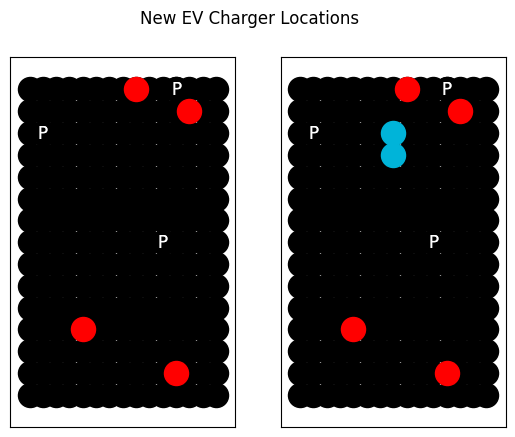

In [26]:
# Print results to commnand-line for user
printout_solution(pois, num_poi, charging_stations, num_cs, new_charging_nodes, num_new_cs)

print('------------------------------------------')
# Create scenario output image
save_output_image(G, pois, charging_stations, new_charging_nodes)

In [183]:
obj3 = BinaryQuadraticModel(vartype='BINARY')
for i in range(len(potential_new_cs_nodes)):   
      #Maximize distance to other new charging locations (obj3)
      for j in range(i+1, len(potential_new_cs_nodes)):
        ai = potential_new_cs_nodes[i]
        aj = potential_new_cs_nodes[j]
        dist = -distance(ai, aj)
        quadratic_terms[(i,j)] = dist
obj3.add_quadratic_from(quadratic_terms)

In [187]:
obj3

BinaryQuadraticModel({0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0, 100: 0.0, 101: 0.0, 102: 0.0, 103: 0.0, 104: 0.0, 105: 0.0, 106: 0.0, 107: 0.0, 108: 0.0